# TP 4 - Neural Galerkin

In [27]:
import torch
from torch.autograd import grad as torch_grad
from torch.func import functional_call, jacrev, vmap
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")

torch.set_default_dtype(torch.double)

torch loaded; device is cpu


### Neural network

In [28]:
class mlp(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()
        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range( len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range( len(self.layer_widths)-2):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        inputs = self.hidden_layers[-1].forward(inputs)
        return inputs

In [29]:
SIGMA = 0.05
Z_VAL = torch.tensor([0.5, 0.0], device=device).unsqueeze(0)
MU_MIN, MU_MAX = -0.02, 0.02

### Sampling data

In [30]:
# 1
class SamplerBox:
    def __init__(self, bbox: list):
        self.bbox = torch.tensor(bbox, device=device, dtype=torch.double)
        self.dim = len(bbox)

    def __call__(self, nb_data: int):
        samples = torch.empty((nb_data, self.dim), device=device, dtype=torch.double)
        for i in range(self.dim):
            min_val, max_val = self.bbox[i]
            samples[:, i] = torch.rand(nb_data, device=device, dtype=torch.double) * (max_val - min_val) + min_val
        return samples

# 2
def test_SamplerData():
    print("Testing SamplerBox...")
    # Test 1D
    bbox1d = [[-2.0, 2.0]]
    sampler1d = SamplerBox(bbox1d)
    data1d = sampler1d(100)
    assert data1d.shape == (100, 1), f"1D Shape mismatch: {data1d.shape}"
    assert torch.all(data1d >= -2.0) and torch.all(data1d <= 2.0), "1D Data out of bounds"
    print("1D Sampler test passed.")

    # Test 2D
    bbox2d = [[-1.0, 1.0], [0.0, 5.0]]
    sampler2d = SamplerBox(bbox2d)
    data2d = sampler2d(200)
    assert data2d.shape == (200, 2), f"2D Shape mismatch: {data2d.shape}"
    assert torch.all(data2d[:,0] >= -1.0) and torch.all(data2d[:,0] <= 1.0), "2D Data out of bounds (dim 0)"
    assert torch.all(data2d[:,1] >= 0.0) and torch.all(data2d[:,1] <= 5.0), "2D Data out of bounds (dim 1)"
    print("2D Sampler test passed.")
    print("SamplerBox tests completed.")

In [31]:
test_SamplerData()

Testing SamplerBox...
1D Sampler test passed.
2D Sampler test passed.
SamplerBox tests completed.


In [32]:
# 5
def u_init_fn(x_spatial, mu_param):
    z = Z_VAL.to(x_spatial.device)
    sigma_plus_mu = SIGMA + mu_param.squeeze(-1) 
    
    diff_sq = torch.sum((x_spatial - z)**2, dim=1) 
    denominator = 2 * (sigma_plus_mu)**2
    val = 1 + torch.exp(-diff_sq / denominator)
    return val.unsqueeze(1) 

In [33]:
# 7
# CORRECTED u_exacte_fn
def u_exacte_fn(t, x_spatial, mu_param):
    t_tensor = torch.tensor(t, device=x_spatial.device, dtype=torch.double)
    
    alpha_rot = 2 * torch.pi * t_tensor
    
    cos_alpha = torch.cos(alpha_rot)
    sin_alpha = torch.sin(alpha_rot)
    
    x0 = x_spatial[:, 0]
    x1 = x_spatial[:, 1]
    
    x_rotated_0 = x0 * cos_alpha - x1 * sin_alpha
    x_rotated_1 = x0 * sin_alpha + x1 * cos_alpha
    
    x_rotated = torch.stack([x_rotated_0, x_rotated_1], dim=1)
    return u_init_fn(x_rotated, mu_param)

In [ ]:
# 3
class NeuralGalerkin:
    def __init__(self, network: mlp, sampler_space: SamplerBox, sampler_param: SamplerBox, reg_lambda=1e-6):
        self.network = network.to(device)
        self.sampler_space = sampler_space
        self.sampler_param = sampler_param
        
        self.theta_vec = torch.nn.utils.parameters_to_vector(self.network.parameters()).detach().clone()
        self.nb_params = self.theta_vec.numel()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)
        
        self.reg_lambda = reg_lambda
        self.regularization_matrix = self.reg_lambda * torch.eye(self.nb_params, device=device, dtype=torch.double)

        self.M = None
        self.F = None

    # 4
    def initialisation(self, u_init_func, epochs=1000, nb_samples_per_epoch=1000, print_every=100):
        print("Starting network initialization...")
        self.network.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            x_samples = self.sampler_space(nb_samples_per_epoch) 
            mu_samples = self.sampler_param(nb_samples_per_epoch)
            
            network_input = torch.cat([x_samples, mu_samples], dim=1) 
            
            u_theta_predictions = self.network(network_input) 
            u_target = u_init_func(x_samples, mu_samples) 
            
            loss = torch.mean((u_theta_predictions - u_target)**2)
            
            loss.backward()
            self.optimizer.step()
            
            if (epoch + 1) % print_every == 0:
                print(f"Initialization Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4e}")
        
        self.theta_vec = torch.nn.utils.parameters_to_vector(self.network.parameters()).detach().clone()
        print("Network initialization finished.")

    # 5
    def plot(self, u_exacte_func_at_t, title="Solution Comparison", current_mu=None):
        print(f"Plotting for {title}...")
        self.network.eval() 

        n_points_plot = 50
        x0 = torch.linspace(self.sampler_space.bbox[0,0],
                            self.sampler_space.bbox[0,1],
                            n_points_plot, device=device)
        x1 = torch.linspace(self.sampler_space.bbox[1,0],
                            self.sampler_space.bbox[1,1],
                            n_points_plot, device=device)
        X0, X1 = torch.meshgrid(x0, x1, indexing='ij')
        x_flat = torch.stack([X0.flatten(), X1.flatten()], dim=1)

        if current_mu is None:
            current_mu = (self.sampler_param.bbox[0,0] + self.sampler_param.bbox[0,1]) / 2.0

        mu_flat = torch.full((x_flat.shape[0], 1), current_mu, device=device, dtype=torch.double)
        inp = torch.cat([x_flat, mu_flat], dim=1)

        with torch.no_grad():
            u_nn = self.network(inp).reshape(X0.shape).cpu()
            u_ex = u_exacte_func_at_t(x_flat, mu_flat).reshape(X0.shape).cpu()
        X0 = X0.cpu()
        X1 = X1.cpu()

        plt.figure(figsize=(18, 5))
        plt.suptitle(f"{title} (μ = {current_mu:.3f})")

        plt.subplot(1, 3, 1)
        plt.contourf(X0.numpy(), X1.numpy(), u_nn.numpy(), levels=50, cmap='viridis')
        plt.title("Neural Network Solution $u_\\theta(x)$")
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.contourf(X0.numpy(), X1.numpy(), u_ex.numpy(), levels=50, cmap='viridis')
        plt.title("Exact Solution $u_{exacte}(x)$")
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.contourf(X0.numpy(), X1.numpy(), (u_nn - u_ex).numpy(), levels=50, cmap='coolwarm')
        plt.title("Difference $u_\\theta(x) - u_{exacte}(x)$")
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        plt.colorbar()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    #
    def compute_jacobian(self, x, mu):
        theta_dict = {k: v.detach() for k, v in self.network.named_parameters()}

        def fnet_single(params, x_single, mu_single): 
            return functional_call(self.network, params, (torch.cat([x_single, mu_single.squeeze(0).unsqueeze(0)], dim=0),))
        
        jac_fn = jacrev(fnet_single, argnums=0) 
        all_jac_dicts = vmap(jac_fn, in_dims=(None, 0, 0), out_dims=0)(theta_dict, x, mu)
        
        jac_list = []
        nb_data = x.shape[0]
        for name in theta_dict.keys(): 
            jac_tensor_for_name = all_jac_dicts[name] 
            jac_list.append(jac_tensor_for_name.reshape(nb_data, 1, -1))
        
        return torch.cat(jac_list, dim=-1) 

    # 6
    def compute_M_and_F(self):
        nb_data_mc = 10000 
        x_mc = self.sampler_space(nb_data_mc) 
        mu_mc = self.sampler_param(nb_data_mc) 

        torch.nn.utils.vector_to_parameters(self.theta_vec, self.network.parameters())
        self.network.eval() 

        jacobian = self.compute_jacobian(x_mc, mu_mc) 

        self.M = self.regularization_matrix + torch.einsum("bjs,bjr->sr", jacobian, jacobian) / nb_data_mc
        
        net_in_mc = torch.cat([x_mc, mu_mc], dim=1) 
        net_in_mc.requires_grad_(True)
        
        u_theta_vals = self.network(net_in_mc) 
        
        spatial_grads = torch_grad(outputs=u_theta_vals, inputs=net_in_mc, 
                                   grad_outputs=torch.ones_like(u_theta_vals), 
                                   create_graph=False, retain_graph=False)[0] 
        
        du_dx0 = spatial_grads[:, 0] 
        du_dx1 = spatial_grads[:, 1] 
        
        x0_vals = x_mc[:, 0] 
        x1_vals = x_mc[:, 1] 
        
        L_u_vals = -(2 * torch.pi * x1_vals) * du_dx0 + (2 * torch.pi * x0_vals) * du_dx1 
        
        term_for_F = -L_u_vals.unsqueeze(1) 
        
        self.F = torch.einsum("bji,bj->i", jacobian, term_for_F) / nb_data_mc
        net_in_mc.requires_grad_(False)


    # 6
    def time_loop(self, dt, T_final, u_init_func_for_initialisation, initial_epochs=1000):
        print("\nStarting time loop...")
        if u_init_func_for_initialisation is not None:
             self.initialisation(u_init_func_for_initialisation, epochs=initial_epochs)
        else: 
            torch.nn.utils.vector_to_parameters(self.theta_vec, self.network.parameters())

        u_exact_t0 = lambda x_spatial, mu_param: u_exacte_fn(0.0, x_spatial, mu_param)
        self.plot(u_exact_t0, title="Solution at t = 0.0 (Initial Condition)")

        num_steps = int(T_final / dt)
        current_t = 0.0
        
        for i_step in range(num_steps):
            torch.nn.utils.vector_to_parameters(self.theta_vec, self.network.parameters())
            self.compute_M_and_F()
            
            try:
                M_inv_F = torch.linalg.solve(self.M, self.F)
            except torch.linalg.LinAlgError:
                print(f"Warning: Singular matrix M at t={current_t:.3f}. Using pseudo-inverse.")
                M_pinv = torch.linalg.pinv(self.M) 
                M_inv_F = torch.matmul(M_pinv, self.F)

            self.theta_vec += dt * M_inv_F
            current_t += dt
            
            if (i_step + 1) % max(1, int(num_steps/10)) == 0 or i_step == num_steps -1 : 
                print(f"Time step {i_step+1}/{num_steps}, t = {current_t:.3f}")

        torch.nn.utils.vector_to_parameters(self.theta_vec, self.network.parameters())
        print(f"Time loop finished at t = {current_t:.3f}")

        u_exact_final_t = lambda x_spatial, mu_param: u_exacte_fn(current_t, x_spatial, mu_param)
        self.plot(u_exact_final_t, title=f"Solution at t = {current_t:.3f} (Final)")

## test


--- Testing Initialization (Question 5) ---
Starting network initialization...
Initialization Epoch 200/2000, Loss: 1.9704e-03
Initialization Epoch 400/2000, Loss: 3.7542e-03
Initialization Epoch 600/2000, Loss: 2.8602e-03
Initialization Epoch 800/2000, Loss: 2.2081e-03
Initialization Epoch 1000/2000, Loss: 2.6566e-03
Initialization Epoch 1200/2000, Loss: 2.3192e-03
Initialization Epoch 1400/2000, Loss: 1.3607e-03
Initialization Epoch 1600/2000, Loss: 2.2812e-03
Initialization Epoch 1800/2000, Loss: 2.2874e-03
Initialization Epoch 2000/2000, Loss: 1.4950e-03
Network initialization finished.
Plotting for After Initialization (t=0)...


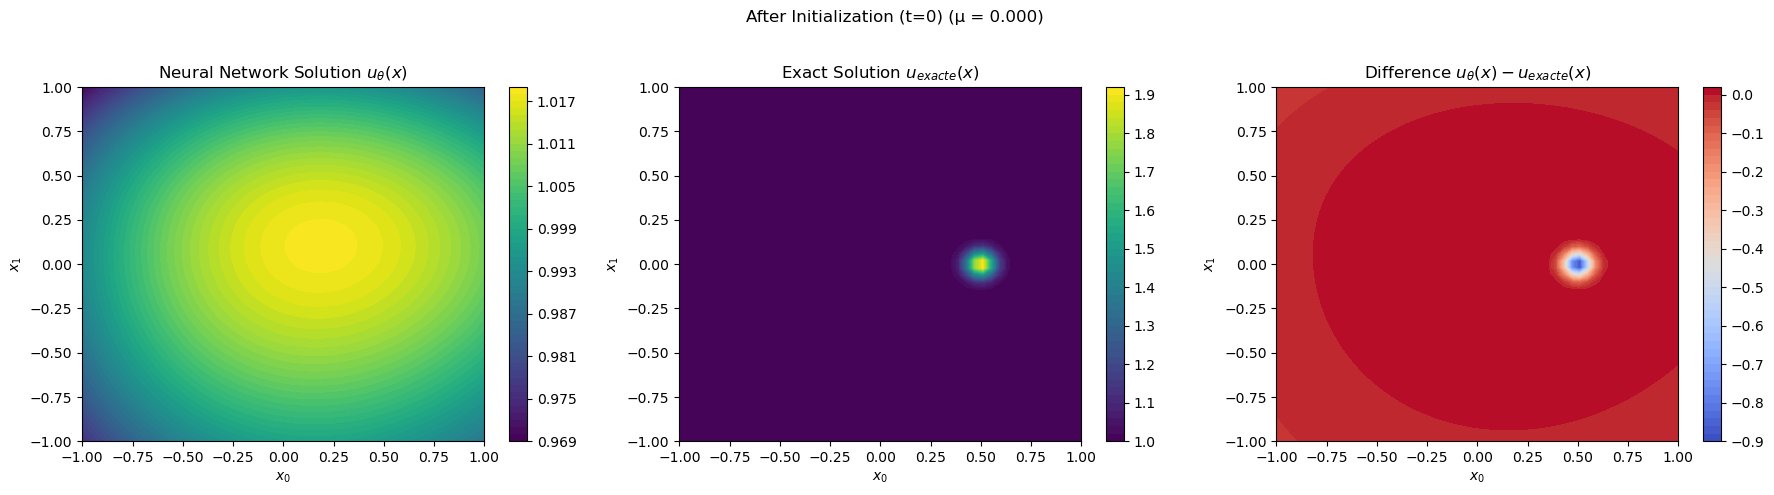

Plotting for After Initialization (t=0, mu_max)...


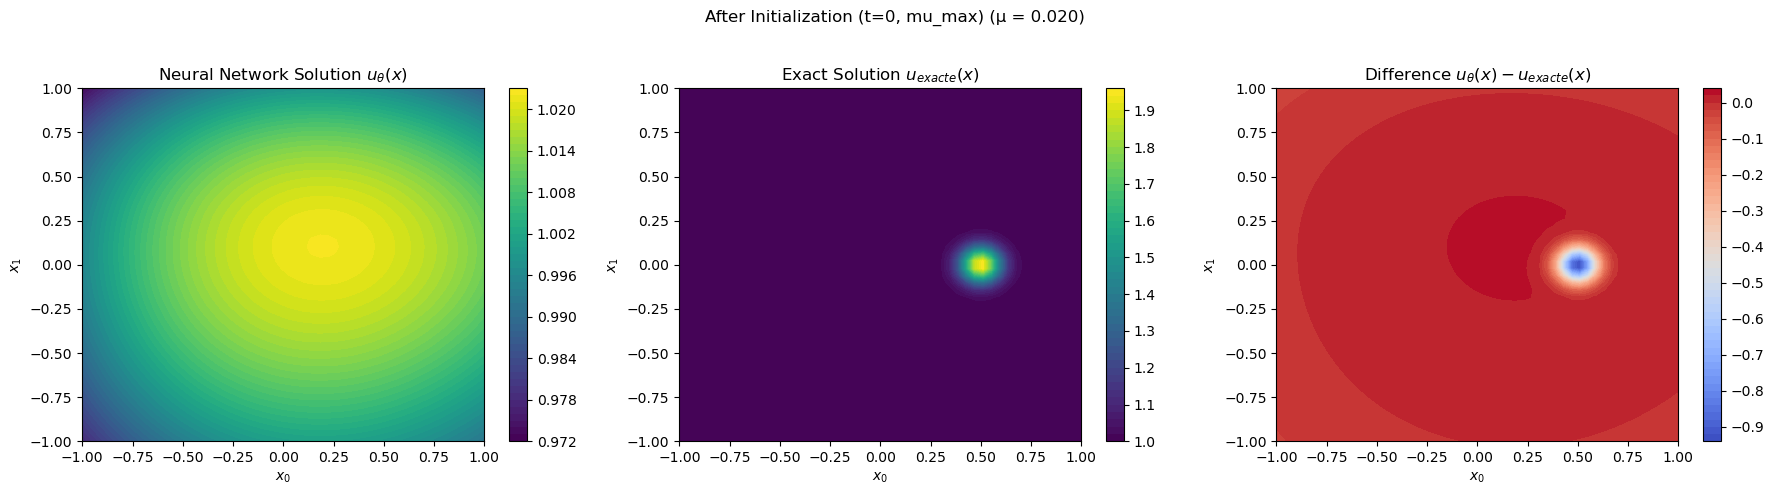


--- Testing Full Time Loop (Question 7) ---

Starting time loop...
Plotting for Solution at t = 0.0 (Initial Condition)...


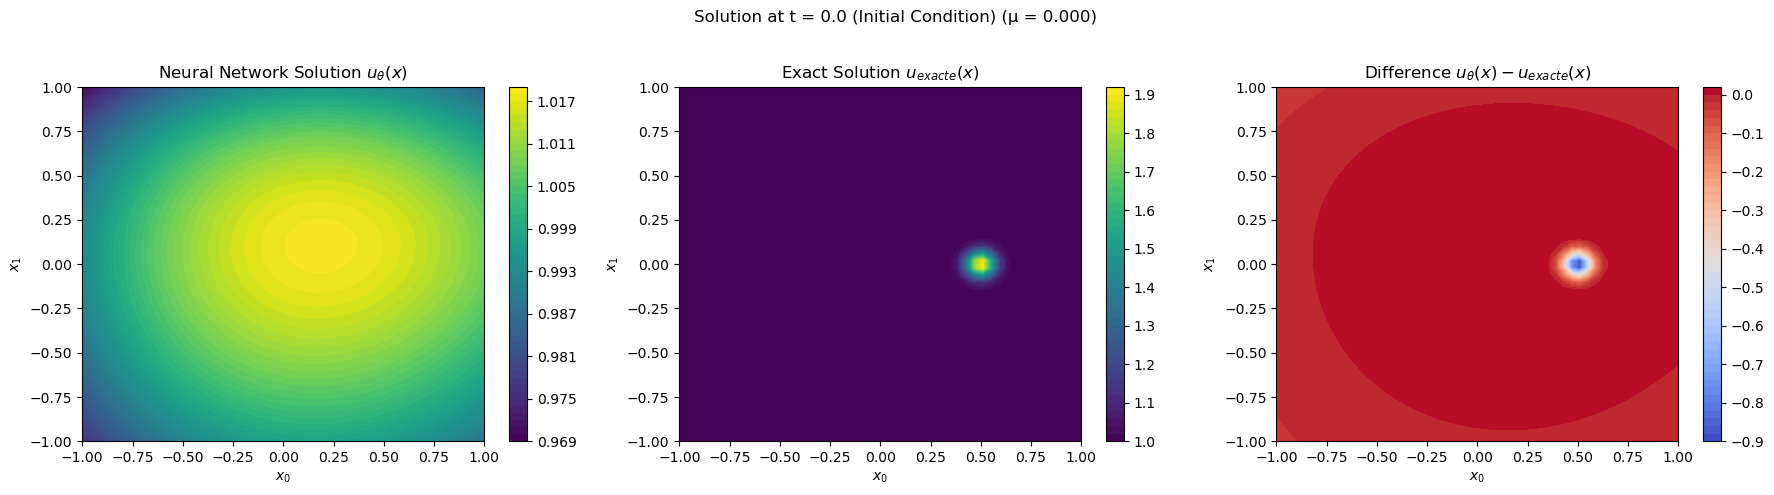

Time step 1/10, t = 0.010
Time step 2/10, t = 0.020
Time step 3/10, t = 0.030
Time step 4/10, t = 0.040
Time step 5/10, t = 0.050
Time step 6/10, t = 0.060
Time step 7/10, t = 0.070
Time step 8/10, t = 0.080
Time step 9/10, t = 0.090
Time step 10/10, t = 0.100
Time loop finished at t = 0.100
Plotting for Solution at t = 0.100 (Final)...


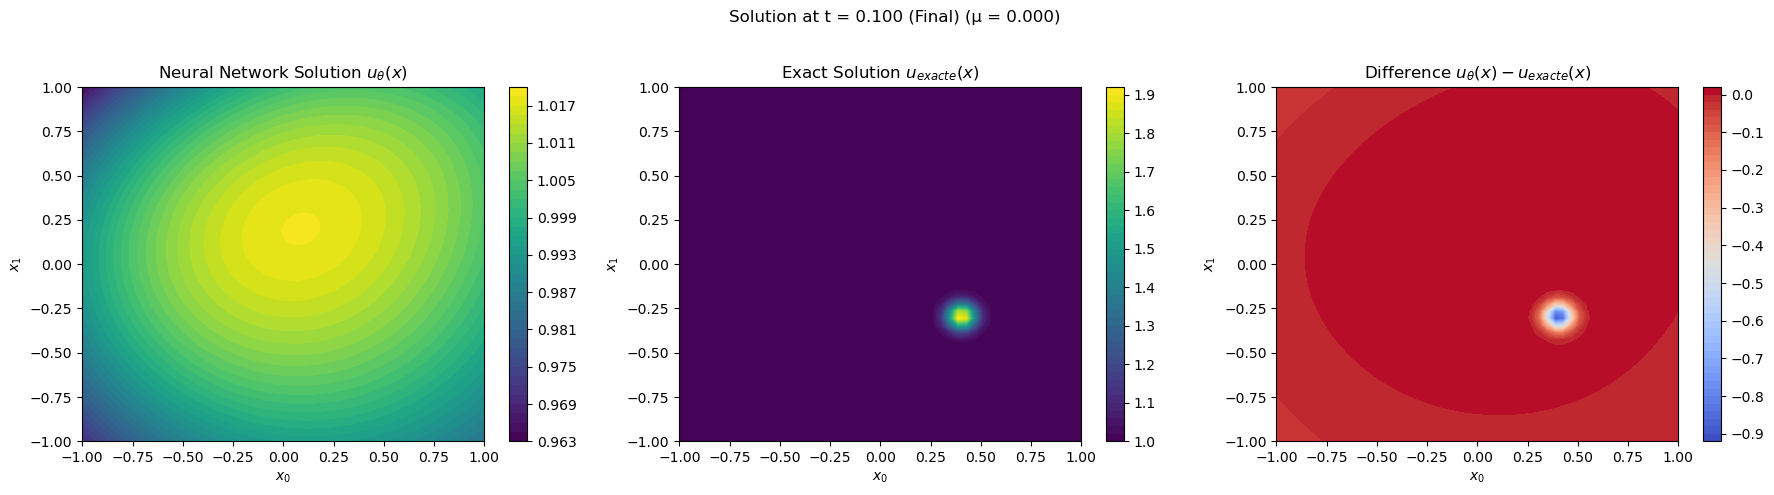

In [35]:
sampler_omega = SamplerBox(bbox=[[-1.0, 1.0], [-1.0, 1.0]])
sampler_mu_range = SamplerBox(bbox=[[MU_MIN, MU_MAX]])

nn_architecture = [3, 30, 30, 1] 
neural_net = mlp(layer_widths=nn_architecture)

ng_solver = NeuralGalerkin(network=neural_net, 
                            sampler_space=sampler_omega, 
                            sampler_param=sampler_mu_range,
                            reg_lambda=1e-7)

print("\n--- Testing Initialization (Question 5) ---")
ng_solver.initialisation(u_init_fn, epochs=2000, nb_samples_per_epoch=2048, print_every=200) 

mu_test_val = 0.0 
u_exact_for_plot_t0 = lambda x_spatial, mu_param_arg: u_exacte_fn(0.0, x_spatial, mu_param_arg)
ng_solver.plot(u_exact_for_plot_t0, title="After Initialization (t=0)", current_mu=mu_test_val)

mu_test_val_max = MU_MAX
ng_solver.plot(u_exact_for_plot_t0, title="After Initialization (t=0, mu_max)", current_mu=mu_test_val_max)

print("\n--- Testing Full Time Loop (Question 7) ---")
delta_t = 0.01  
T_final_sim = 0.1   

ng_solver.time_loop(dt=delta_t, T_final=T_final_sim, u_init_func_for_initialisation=None)